# Entrega 1: Entendimiento de los datos

## Introducción
    Estás son las actividades realizadas para lograr el entendimiento de datos para el cliente WWImporters. El documento incluye lo siguiente:
    0. Configuración del entorno y creación de sesión de trabajo
    1. Perfilamiento de datos
    2. Análisis de la calidad de datos
    3. Conclusión del entendimiento de datos
    


## Configuración y creación de sesión de trabajo
Se importan los paquetes requeridos para el análisis y se inicializaza la sesión de trabajo.

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

Configuración del controlador e inicio de sesion Spark

In [8]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [11]:
#Configuración de la sesión
#spark.stop()
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

In [12]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/WWImportersTransactional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_58_202413'
db_psswd = 'aabb1122'

PATH='./'

## Perfilamiento de los datos
El perfilamiento desarrollado aborda los siguientes aspectos: **entendimiento general** de los datos compartidos, validación de **reglas de negocio**, **análisis descriptivo** utilizando estadística descriptiva y diagramas para la visualización de los datos .


### Información dada por la organización relacionada con los datos
El grupo de consultores de analitica descriptiva de Wide World Importers asegura que las tablas Grupo de compras, Ciudades, Colores, Paises, Clientes, Categorias de clientes, Paquetes, Estados y provincias, Productos y Personas ya fueron perfiladas y corregidos; sin embargo le recomiendan revisar el diccionario suministrado dado que todas las tablas serán utilizadas en futuros requerimientos (tutoriales y ejercicios) que lo encuentra [aqui](./Diccionario%20WWImporters.xlsx). Si tienen alguna duda relacionada con estas tablas deben incluirla en las preguntas o aclaraciones que le entreguen a la organización como parte del resultado de esta fase de entendimiento.

En este punto de la consultorìa, nuestra responsabilidad es analizar las tabla movimientosCopia y nos comentan lo siguiente:

- La cantidad máxima de productos movidos es 50 millones por transacción
- Existen 236.668 movimientos de producto realizados desde 2013
- Los movimientos están relacionados con 228.265 clientes
- El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
- Actualmente tenemos 13 proveedores


### Conexión a fuente de datos y acceso a los datos

#### Conexión a fuente de datos
A continuación encuentra las funciones para conectarse a la fuente de datos y retornar un dataframe que es el que se utilizará posteriormente para manipular los datos.

In [14]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Carga de datos
Se cargan los datos para las tablas de Movimientos, Proveedores, Clientes y Productos

In [28]:
sql_movimientos = 'WWImportersTransactional.movimientosCopia'

In [105]:
#Se cargan los dataframes desde la base de datos
movimientos = obtener_dataframe_de_bd(db_connection_string, sql_movimientos, db_user, db_psswd)
#obtener_dataframe_de_bd(db_connection_string, 'WWImportersTransactional.TiposTransaccion', db_user, db_psswd).show()

+-----------------+---------------------+
|TipoTransaccionID|TipoTransaccionNombre|
+-----------------+---------------------+
|                2| Customer Credit Note|
|                3| Customer Payment ...|
|                4|      Customer Refund|
|                5|     Supplier Invoice|
|                6| Supplier Credit Note|
|                7| Supplier Payment ...|
|                8|      Supplier Refund|
|                9|       Stock Transfer|
|               10|          Stock Issue|
|               11|        Stock Receipt|
|               12| Stock Adjustment ...|
|               13|      Customer Contra|
+-----------------+---------------------+



### Entendimiento general de datos

Se visualiza en forma parcial la información de cada una de las tablas

In [21]:
movimientos.show(5)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
|               290145|       213|               10|     33.0|  60795.0|           |               |     Dec 23,2015|    -3.0|
|               247492|        90|               10|     55.0|  51851.0|           |               |     Jul 27

A continuación se muestran los esquemas del DataFrame

In [56]:
movimientos.schema

StructType(List(StructField(TransaccionProductoID,IntegerType,true),StructField(ProductoID,IntegerType,true),StructField(TipoTransaccionID,IntegerType,true),StructField(ClienteID,DoubleType,true),StructField(InvoiceID,DoubleType,true),StructField(ProveedorID,StringType,true),StructField(OrdenDeCompraID,StringType,true),StructField(FechaTransaccion,StringType,true),StructField(Cantidad,DoubleType,true)))

Analizando el esquema de la tabla de movimientos, podemos encontrar que se encuentra información del producto, del proveedor, del cliente y de la orden de compra. Además se registra el tipo de transacción el identificador de factura la fecha de la transacción y la cantidad.

El identificador de la transacción parece estar definido por el campo TransaccionProductoID pero por la nomenclatura, no está claro.

Realizando una revisión rápida de los datos contenidos, se encuentra algunos aspectos a revizar en detalle más adelante como por ejemplo: cantidades negativas, y referencias vacías a proveedores y a ordenes, además . Por último, la fecha no parece seguir el formato indicado por el cliente. Identificador de proveedor y orden de compra de tipo caracter


A continuación, se imprimen las cantidades de registros y columans de la tabla:

In [106]:
print((movimientos.count(), len(movimientos.columns)))

(204292, 9)


**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 204292 registros de movimientos y 9 variables a revisar de las cuales 3 son numéricas enteras asociadas a identificados, 3 de tipo numéricas flotantes asociadas a identificadores y campo cantidad y las demás son cadenas de caracteres asociadas a identificadores y campo fecha.

### Revisión de reglas de negocio 

Primero se confirman las reglas proporcionadas por el negocio, La cantidad máxima de productos movidos es 50 millones por transacción. 

In [51]:
movimientos.agg({"Cantidad": "max"}).show()

+-------------+
|max(Cantidad)|
+-------------+
|      67368.0|
+-------------+



La máxima cantidad registrada para una transacción es de 67.368 por lo que la primera regla de negocio no es cierta.  

La siguiente regla indica que existen 236.668 movimientos de productos registrados desde el 2013. Como la cantidad total de movimientos es de 204.292, tampoco se cumple.

La siguiente regla indica que hay movimientos registrados con 228.265 cliente.

In [52]:
movimientos.select("ClienteID").distinct().count()

664

Como se puede observar, solo hay 664 clientes distintos en los movimientos registrados proporcionados por lo que tampoco se cumple esta regla

In [ ]:
La siguiente regla indica que el formato de la fecha es de YYYY-MM-DD HH:MM:SS. Entonces para comprobarlo ejecutamos:

57981

In [53]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = movimientos.filter(movimientos["FechaTransaccion"].rlike(regex))
print("Número total de movimientos: "+str(movimientos.count())+", número de movimientos con formato de fecha correcto: "+str(cumplenFormato.count()))

Número total de movimientos: 204292, número de movimientos con formato de fecha correcto: 140038


Como se puede observar, del total solo hay 140038 registros qe cumplement con el formato, por lo que la regla solo se cumple para el 68.5% de los movimientos registrados

Por último, se nos indica que hay 13 proveedores distintos. Al verificar con:

In [54]:
movimientos.select("ProveedorID").distinct().count()

4

Por lo que podría tomarse como válido ya que 4 es menor que el máximo que es 13.

Por otro lado, si bien no es una regla del cliente, nos llama la atención la cantidad de tipos de datos distintos para representar las referencias a otras entidades. Entiendo que la organización debe ser notificada para unificar el criterio a aplicar y evitar errores en las relaciones entre entidades distintas. 

### Análisis descriptivo
Una vez cubierto lo básico de reglas de negocio, pasamos a perfilamiento estadístico. Para ver estadisticos generales como conteo, mínimo, máximo, desviación estandar y percentiles utilice summary()

In [59]:
movimientos.summary().show()

+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|summary|TransaccionProductoID|        ProductoID|  TipoTransaccionID|         ClienteID|        InvoiceID|      ProveedorID|   OrdenDeCompraID|    FechaTransaccion|         Cantidad|
+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|  count|               204292|            204292|             204292|            204292|           204292|           204292|            204292|              204292|           204292|
|   mean|   212458.04047637695|110.70090850351458| 10.035253460732676| 517.3252941867523|42957.26929590978|4.951898734177215|1345.9973277074544|                null|719.4997650421946|
| stddev|    71352.37579752573| 63.49014746219581|0.18563716955046372|353.501369

En las estadísticas anteriores vemos que las cantidaes de registros son 204.292 como se mencionó anteriormente. La media y la desviación estandarsolo tiene sentido analizarla para el campo Cantidad que es de casi 719.5 y 4729.37 respectivamente. En cuanto al valor mínimo, las columnas ClienteID y ProveedoID tienen como valor mínimo 0.0 lo cuál es extraño ya que son identificadores de entidades. También aparecen registros de movimientos sin referencias a proveedores y ordenes de compra lo que puede indicar que no corresponde para la operación pero hay que verificar. El valor mínimo de cantidad es negativo lo cuál indica que hay operaciones de disminución de la cantidad del producto y la mayoría son de este tipo lo que se ratifica con que la mayoría del tipo de trasacción es de tipo 10. Con respecto al resto de los valores, solo destacar nuevamente la gran cantidad de registros con cantidades negativas y las diferencias entre el mínimo y máximo valor de los identificadores encontrados.

Para tener un análisis más detallado de la variable Cantidad, utilizaremos el  los siguiente diagrams de caja donde se observa claramente que tenemos un valor extremo en la variable cantidad y donde podemos ver los valores extremos o bigotes que determinan el punto de separación entre valores atípicos y normales, los valores atipicos, los cuartiles entre otros

{'whiskers': [<matplotlib.lines.Line2D at 0x209a5dd86c8>,
 'caps': [<matplotlib.lines.Line2D at 0x209a5624b08>,
 'boxes': [<matplotlib.lines.Line2D at 0x209aafcc888>],
 'medians': [<matplotlib.lines.Line2D at 0x209a8ea6208>],
 'fliers': [<matplotlib.lines.Line2D at 0x209a8ea6848>],
 'means': []}

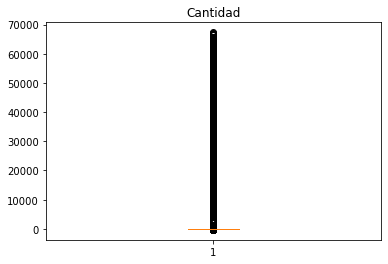

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad')
ax1.boxplot(np.array(movimientos.select('Cantidad').collect()))

## Análisis de calidad de datos
En este análisis se resalta:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores

A continuación se definen dos funciones, la primera cuenta los valores vacios por columna de dataframe, la segunda retorna un diccionario de columnas con cardinalidad superior al 50%

### Unicidad y validez

La unicidad la podemos verificar con: se revisó en la segunda regla de negocio.

In [79]:
movimientos.count() - movimientos.distinct().count()

30633

Donde encontramos que hay 30.633 registros duplicados, es decir casi un 15% de los registros.

La validez se reviso en el perfilamiento general

### Completitud y validez

In [81]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(col(c).isNull()).count()
        
        if dict(df.dtypes)[c] == 'string':
            vacios += df.filter((col(c).isNull()) | (col(c) == '')).count()
            
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def contar_negativos(df):
    resultados = []
    for c in df.columns:
        dtype = dict(df.dtypes)[c]
        if dtype in ['int', 'bigint', 'float', 'double', 'decimal']:
            negativos = df.filter(col(c) < 0).count()
            resultados.append((c, negativos))
            print(f'Número de valores negativos en la columna "{c}": {negativos}')
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [76]:
cv=contar_vacios(movimientos)

número de vacíos para columna ProveedorID: 197182
número de vacíos para columna OrdenDeCompraID: 197182


[197182, 197182]

In [72]:
cardinalidad(movimientos)

{'TransaccionProductoID': 173659}

Como podemos observar para los movimientos registrados las columnas ProveedorID y OrdenDeCompraID tienen 197.182 registros vacíos lo que implica un 96.5% del total 

Respecto a cardinalidad, solo la columna TransaccionProductoID tiene una cardinalidad superior al 50%.

### Consistencia
A nivel de consistencia vamos a resaltar que la cantidad de valores negativos es consistente con la cantidad de operaciones de un mismo tipo encontrado en el análisis anterior.

In [83]:
n=contar_negativos(movimientos)

Número de valores negativos en la columna "TransaccionProductoID": 0
Número de valores negativos en la columna "ProductoID": 0
Número de valores negativos en la columna "TipoTransaccionID": 0
Número de valores negativos en la columna "ClienteID": 0
Número de valores negativos en la columna "InvoiceID": 0
Número de valores negativos en la columna "Cantidad": 197158


In [ ]:
El resultado indica que para la variable cantidad el 96.5% de los valores son negativos y según el análisis anterior, la mayoría de las operaciones son del mismo tipo

## Herramientas para facilitar el entendimiento de datos

Para la generación de un reporte estadístico en HTML, utilizamos Pandas Profiling

In [77]:
reporte = ProfileReport(movimientos.toPandas())
reporte.to_file(PATH+"reporte_prefilamiento.html")

Summarize dataset:  60%|██████    | 12/20 [00:02<00:01,  6.87it/s, Calculate kendall correlation]         C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 81.20it/s]


A modo de resumen, para cada sección del reporte encontramos:
Seccion general del reporte:
1. Tenemos 9 variables y 204.292 registros (es decir, movimientos), de las cuales 5 son numericas y 4 categoricas

2. En los datos hay 0% de datos vacíos, (conclusión)

3. El archivo ocupa en memoria 11.7 MB

4. El 15% de los registros están duplicados

Sección de variables del reporte:

5. Un porcentaje de las variables ClienteID e InvoiceID tienen cero como valor lo cuál al ser referencias de otras entidades, no debería ser posible.

6. La variable ProductoID, ClienteID, OrderDeCompraID y FechaTransaccion tienen muy pocos valores distintos lo que indica pocos cliente y proveedores, y los movimientos se refieren a pocas ordenes de compras distintas referidas a las mismas fechas.


Sección de interacciones y correlaciones:
7. La mayoria de las cantidades son negativas lo que coincide con que la mayoria de las transacciones son de tipo 10, lo cuál tiene sentido.La mayoria de las cantidades son negativas lo que coincide con que la mayoria de las transacciones son de tipo 10, lo cuál tiene sentido.


## Conclusiones/resultados

#### **Conclusiones generales:**

1. En la tabla de movimientos tenemos información relacionada con **n el producto, la cantidad movida, la fecha y otras entidades relevantes como clientes, proveedores y ordenes de comrpa**
2. Una fila de movimiento representa un movimiento específico de un producto fruto de la ejecución de una determinada transacción.

**Conclusiones de reglas de negocio:**

1. La regla 1 no es cierta ya que la cantidad máxima de productos movidos es menor al número informado.

2. La regla 2 no es cierta ya que la cantidad total de registros es de 204292, es decir, es menor al número informado. 

3. La regla 3 no es cierta ya que solo se encontraron 664 clientes distintos.

4. Para la regla 4, más del 30% de los registros no cumplen con el formato de fecha establecido.

5. La regla 5 es correcta ya que la cantidad de proveedores unicos es menor al número informado.

**Conclusiones de calidad:**

1. Hay un 15% de registros duplicados que hay que eliminar

2. La mayoría de los registros no tienen datos de proveedor ni orden de compra lo que indica que quizas esas columnas no sean 100% necesarias

3. La mayoría de las operaciones son del mismo tipo

4. Se utilizan distintos tipos de datos para definir representar identificadores de entidades lo cuál hay que corregir.

**Usando herramientas:**

Seccion general del reporte:
1. Tenemos 9 variables y 204.292 registros (es decir, movimientos), de las cuales 5 son numericas y 4 categoricas

2. En los datos hay 0% de datos vacíos, (conclusión)

3. El archivo ocupa en memoria 11.7 MB

4. El 15% de los registros están duplicados

Sección de variables del reporte:

5. Un porcentaje de las variables ClienteID e InvoiceID tienen cero como valor lo cuál al ser referencias de otras entidades, no debería ser posible.

6. La variable ProductoID, ClienteID, OrderDeCompraID y FechaTransaccion tienen muy pocos valores distintos lo que indica pocos cliente y proveedores, y los movimientos se refieren a pocas ordenes de compras distintas referidas a las mismas fechas.

7. La mayoria de las cantidades son negativas lo que coincide con que la mayoria de las transacciones son de tipo 10, lo cuál tiene sentido.5. Un porcentaje de las variables ClienteID e InvoiceID tienen cero como valor lo cuál al ser referencias de otras entidades, no debería ser posible.

6. La variable ProductoID, ClienteID, OrderDeCompraID y FechaTransaccion tienen muy pocos valores distintos lo que indica pocos cliente y proveedores, y los movimientos se refieren a pocas ordenes de compras distintas referidas a las mismas fechas.

Sección de correlación:

7. La mayoria de las cantidades son negativas lo que coincide con que la mayoria de las transacciones son de tipo 10, lo cuál tiene sentido.La mayoria de las cantidades son negativas lo que coincide con que la mayoria de las transacciones son de tipo 10, lo cuál tiene sentido.


**Conclusiones de consultoria**

![Requerimiento](./Requerimiento.PNG)

Teniendo en cuenta el requerimiento de WWI, consideramos que es posible llevar a cabo una solucióon pues contamos con la información necesaria especificada en el análisis requerido, sin embargo es necesario realizar correcciones a los datos y obtener aclaraciones de parte del negocio para entender completamente la necesidad de negocio